# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [66]:
student1 = "Oussama Abouzaid"
student2 = "Lucas Gauchoux"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [67]:
# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
import numpy as np
np.random.seed(hash(student1 + student2) % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

In [68]:
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
import warnings
warnings.filterwarnings('ignore')

### Plotting

In [69]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    plt.grid()
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    plt.grid()
    #return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), where we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [70]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('data/housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('data/housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We further reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [71]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

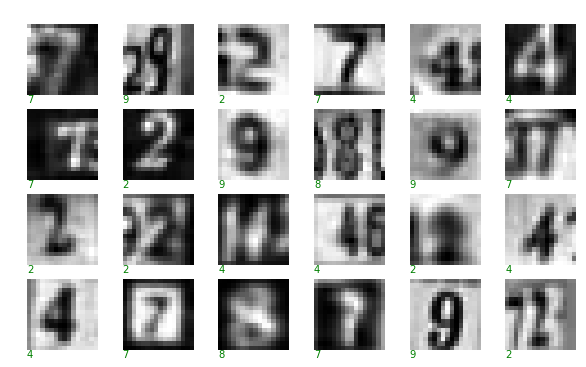

In [72]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [73]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [158]:
model = Sequential()
model.add(Dense(units=5, input_dim=256, activation= 'softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=500, batch_size=128, verbose=0)
acc = model.evaluate(x_test, y_test, verbose=0)

In [159]:
print("Accuracy = {}%".format((acc[1]*100)))

Accuracy = 36.74571495679582%


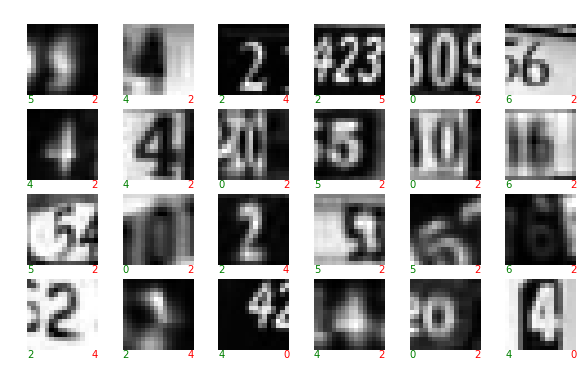

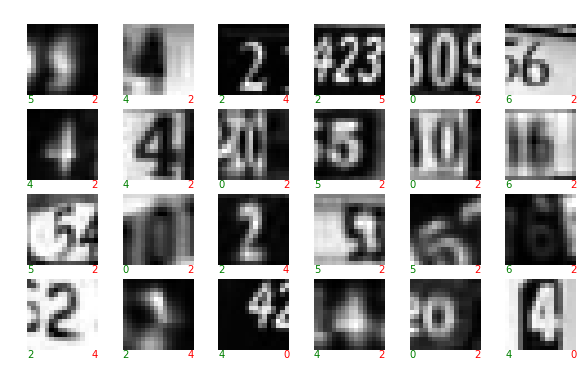

In [219]:
yhat_test = model.predict(x_test)
error_indices = np.where(np.argmax(yhat_test, axis = 1) != np.argmax(y_test, axis = 1)) # misclassified images
plot_some_samples(x_test, y_test, yhat_test, idx, label_mapping = subset_of_classes)

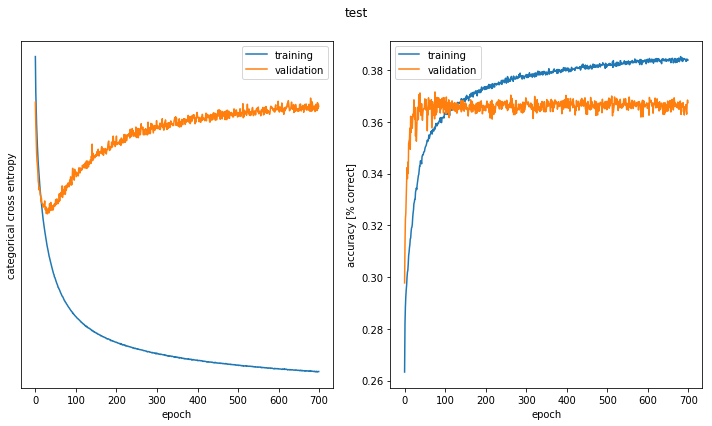

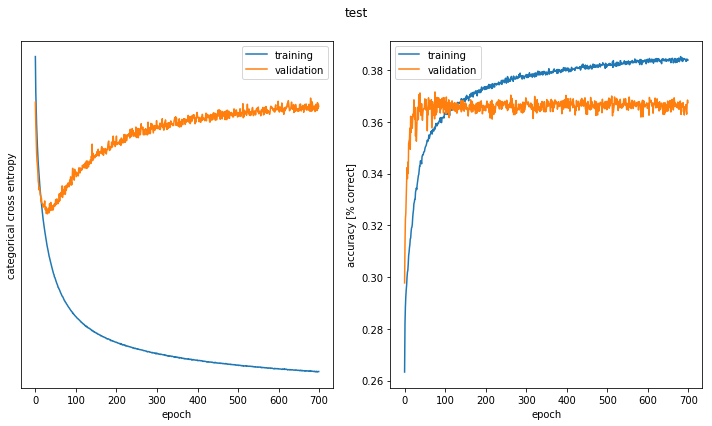

In [23]:
plot_history(history, 'test')

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

### 1. One hidden layer with 64 units

In [30]:
x_train.shape

(34887, 256)

In [9]:
model2 = Sequential([Dense(units=64, input_dim=256, activation= 'relu'), Dense(5,activation= 'softmax')])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


### 2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent

In [10]:
# define 4 SGD optimizers, each with a different learning rate
sgds = [SGD(lr=rate, decay=1e-6, momentum=0.9, nesterov=True) for rate in [0.001, 0.01, 0.1, 0.3]]

In [11]:
# Run SGD for the learning rates 0.001, 0.01, 0.1, 0.3
history = []
accuracy = []

for sgd in sgds:
    print('Lambda = {}'.format(str(sgd.lr)))
    m = Sequential([Dense(units=64, input_dim=256, activation= 'relu'), Dense(5,activation= 'softmax')])
    m.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    hist = m.fit(x_train, y_train, validation_data= (x_test, y_test), batch_size=128, epochs=50, verbose=0)
    acc = m.evaluate(x_test, y_test, verbose=0)
    history.append(hist)
    accuracy.append(acc)

Lambda = <tf.Variable 'SGD/lr:0' shape=() dtype=float32_ref>
Lambda = <tf.Variable 'SGD_1/lr:0' shape=() dtype=float32_ref>
Lambda = <tf.Variable 'SGD_2/lr:0' shape=() dtype=float32_ref>
Lambda = <tf.Variable 'SGD_3/lr:0' shape=() dtype=float32_ref>


**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) The alogrithm doesn't converge, the accuracy is constant at a very low level (around 27%)

B) The convergence is too slow

### 3. Adam optimizer

In [23]:
adam = Sequential([Dense(units=64, input_dim=256, activation= 'relu'), Dense(5,activation= 'softmax')])
adam.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_adam = adam.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=50, verbose=0)
acc_adam = adam.evaluate(x_test, y_test, verbose=0)

In [50]:
for i in range(len(accuracy)):
    lr = round(sgds[i].get_config()['lr'], 3)
    print("SGD optimizer using lr = {}, Accuracy= {}%".format(lr, round(accuracy[i][1]*100, 3)))
print("Adam optimizer, Accuracy= {}%".format(round(acc_adam[1]*100, 3)))

SGD optimizer using lr = 0.001, Accuracy= [1.1019818811542694, 0.6231531881804043]%
SGD optimizer using lr = 0.01, Accuracy= [0.6350811354665327, 0.817651632970451]%
SGD optimizer using lr = 0.1, Accuracy= [0.7127845039356552, 0.8224144634525661]%
SGD optimizer using lr = 0.3, Accuracy= [0.8754381498272645, 0.7454315707620529]%
Adam optimizer, Accuracy= [0.660556353501176, 0.8259136858475894]%


### 4. Plot of the learning curves

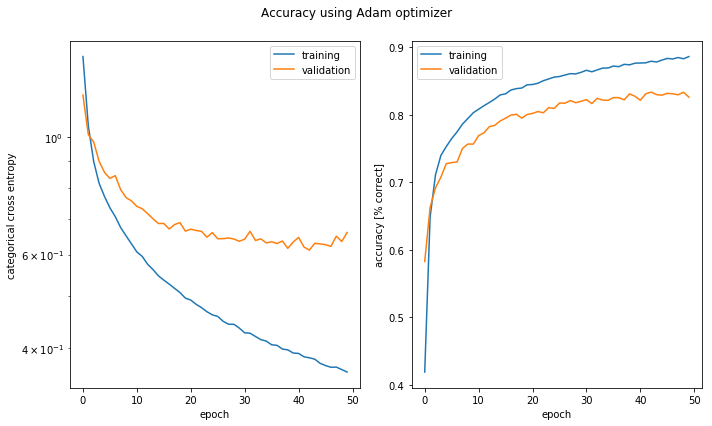

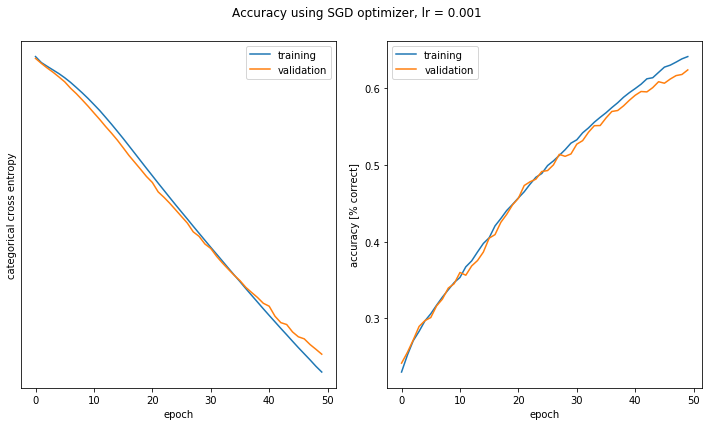

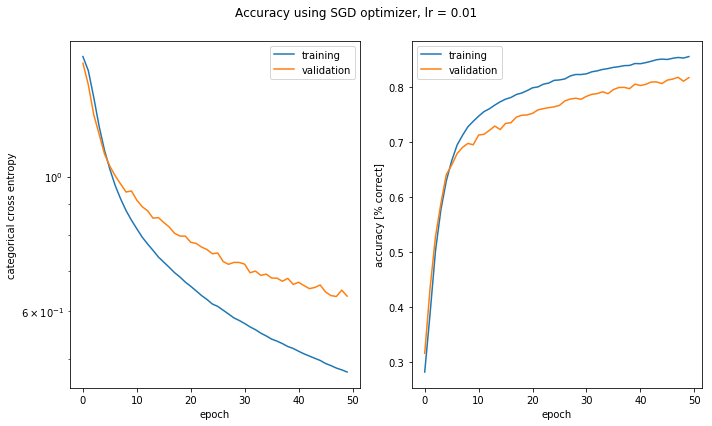

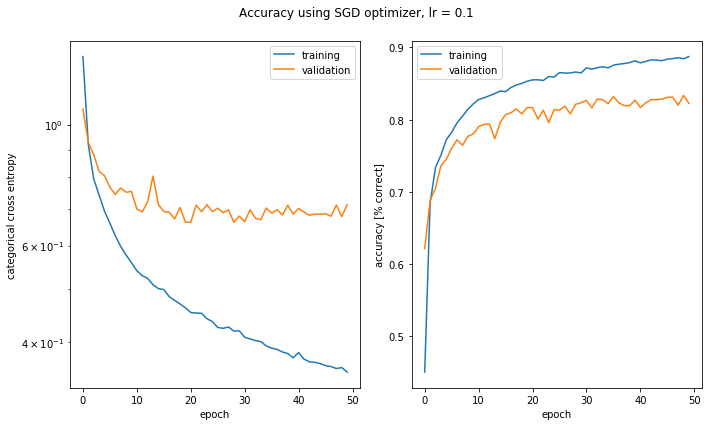

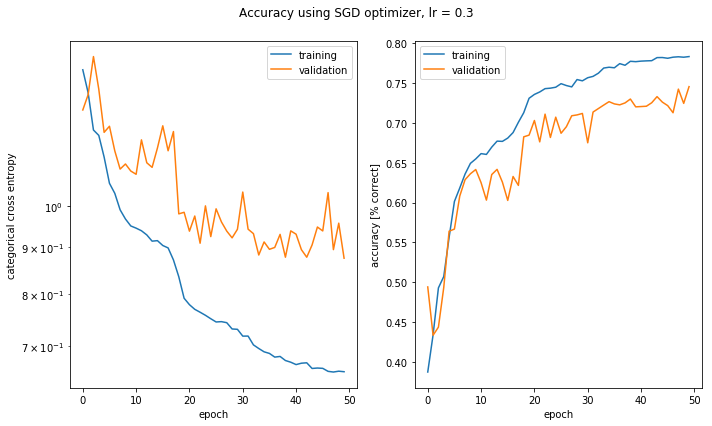

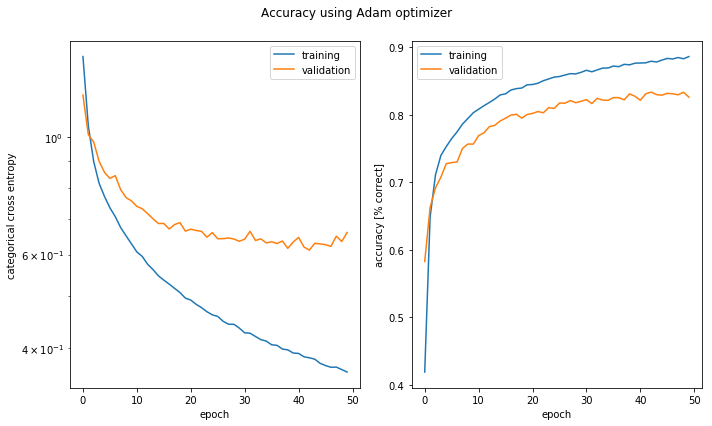

In [25]:
for i in range(len(history)):
    lr = round(sgds[i].get_config()['lr'], 3)
    plot_history(history[i], 'Accuracy using SGD optimizer, lr = {}'.format(lr))
plot_history(hist_adam, 'Accuracy using Adam optimizer')

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [38]:
adam2 = Sequential([Dense(units=64, input_dim=256, activation= 'relu'), Dense(5,activation= 'softmax')])
adam2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
callback = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=500, verbose=1, mode='auto')]
hist_adam2 = adam2.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=700, verbose=0, callbacks= callback)
acc_adam2 = adam2.evaluate(x_test, y_test, verbose=0)


Epoch 00522: early stopping


In [45]:
print("Accuracy using Adam optimizer with early stopping = {}%".format(round(acc_adam2[1]*100, 4)))
acc_adam2

Accuracy using Adam optimizer with early stopping = 83.437%


[1.1332740390768874, 0.8343701399688958]

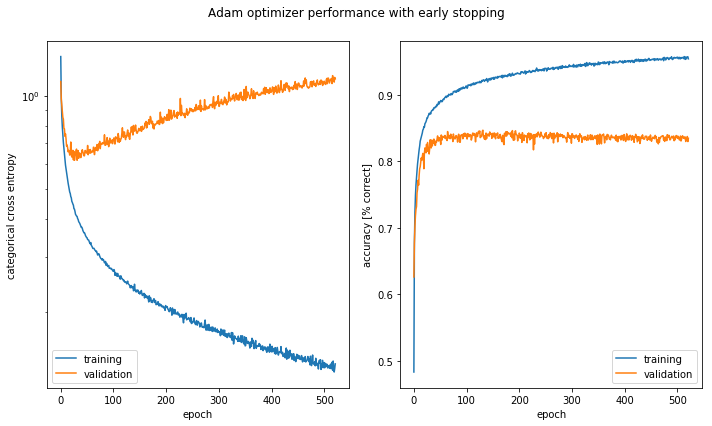

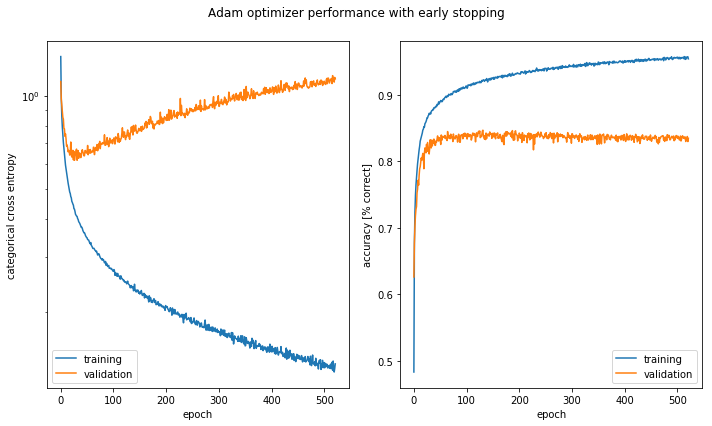

In [40]:
plot_history(hist_adam2, 'Adam optimizer performance with early stopping')

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: After approximately 50 epochs

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 
        1. Concerning the accuracy curves, we see that there is a significant gap between both curves, the validation accuracy is smaller compared to the training accuracy, so there is clear overfitting.       
    
        2. Concerning the loss curves, we see that at 50 epochs approximately, the validation loss starts to increase and diverge from the validation loss, which is once again a sign of overfitting.

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

### 1.

In [59]:
hidden_n = [10, 100, 500, 1000]
# Set up a callback
callback_4 = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=100, verbose=1, mode='auto')]

# Models for Adam optimizer 

models_adam = [Sequential([Dense(units= n, input_dim=256, activation= 'relu'),
                    Dense(5,activation= 'softmax')]) for n in hidden_n]

# Models for SGD  (using lr = 0.01)

models_sgd = [Sequential([Dense(units= n, input_dim=256, activation= 'relu'),
                    Dense(5,activation= 'softmax')]) for n in hidden_n]

# Compile the models 

for a, s in zip(models_adam, models_sgd):
    a.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    s.compile(optimizer=sgds[1], loss='categorical_crossentropy', metrics=['accuracy']) # lr = 0.01

In [60]:
# Fit the Adam models 
history_adam = []
accuracy_adam = []
for a in models_adam:
    h = a.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=200, verbose=0, callbacks= callback_4)
    history_adam.append(h)
    acc = a.evaluate(x_test, y_test, verbose=1)
    accuracy_adam.append(acc)

Epoch 00122: early stopping
10288/10288 [==============================] - 0s 33us/step
Epoch 00125: early stopping
10288/10288 [==============================] - 0s 32us/step
Epoch 00112: early stopping
10288/10288 [==============================] - 0s 40us/step
Epoch 00112: early stopping
10288/10288 [==============================] - 1s 64us/step


In [61]:
accuracy_adam

[[0.9812114600260188, 0.698094867807154],
 [0.7701847281532933, 0.8451594090202177],
 [0.9607257185211263, 0.8466174183514774],
 [1.0502286484619077, 0.8390357698289269]]

### The best performance is given by 100 neurons

In [ ]:
# Fit the SGD models 
history_sgd = []
accuracy_sgd = []
for s in models_adam:
    h = s.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=200, verbose=0, callbacks= callback_4)
    history_sgd.append(h)
    acc = s.evaluate(x_test, y_test, verbose=0)
    accuracy_sgd.append(acc)

### 2. Collect the statistics by fitting the above models with different initial conditions

### 3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons

### 4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons

# Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

model with 100 hidden neurons in 1 hidden layer ==> **26205 params**

# Model with 1 hidden layer of 100 neurons

In [62]:
model_1l = Sequential([Dense(units=100, input_dim=256, activation= 'relu'),
                    Dense(5,activation= 'softmax')])
model_1l.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_1l = model_1l.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=100, verbose=0)
acc_1l = model_1l.evaluate(x_test, y_test, verbose=0)
model_1l.summary()
print(acc_1l)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_167 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_168 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
[0.7394872868251096, 0.8368001555209953]


In [255]:
m1 = Sequential([Dense(units=100, input_dim=256, activation= 'relu'),
                    Dense(5,activation= 'relu')])

m2 = Sequential([Dense(units=100, input_dim=256, activation= 'relu'),
                    Dense(5,activation= 'relu')])

m3 = Sequential([Dense(units=100, input_dim=256, activation= 'relu'),
                    Dense(5,activation= 'softmax')])

m4 = Sequential([Dense(units=100, input_dim=256, activation= 'relu'),
                    Dense(5,activation= 'softmax')])

m1.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])
m2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
m3.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
m4.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

hist_m1 = m1.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=100, verbose=0)
hist_m2 = m2.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=100, verbose=0)
hist_m3 = m3.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=100, verbose=0)
hist_m4 = m4.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=100, verbose=0)

acc_m1 = m1.evaluate(x_test, y_test, verbose=0)
acc_m2 = m2.evaluate(x_test, y_test, verbose=0)
acc_m3 = m3.evaluate(x_test, y_test, verbose=0)
acc_m4 = m4.evaluate(x_test, y_test, verbose=0)

m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_83 (Dense)             (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________


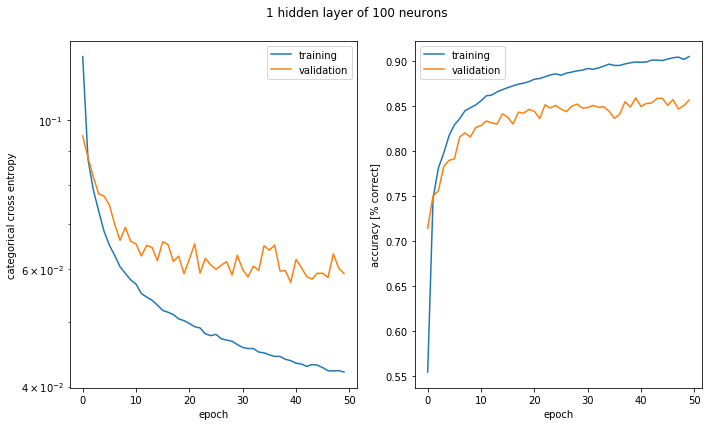

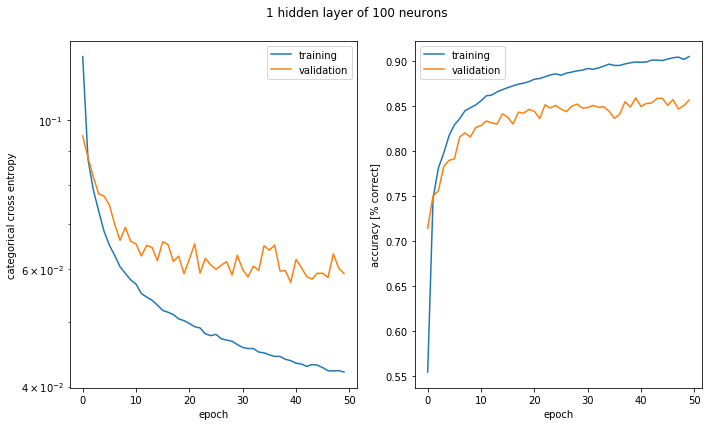

In [246]:
plot_history(hist_adam5, '1 hidden layer of 100 neurons')

with relu, softmax and cat_crossentropy

In [256]:
adam5.evaluate(x_test, y_test, verbose=0)

[0.5329250767891177, 0.8717226265993273]

with 2 relu and mse

In [254]:
adam5.evaluate(x_test, y_test, verbose=0)

[0.05902305667814798, 0.856695624960414]

In [257]:
model_2l = Sequential([Dense(units=77, input_dim=256, activation= 'relu'), 
                       Dense(77,activation= 'relu'), 
                       Dense(5,activation= 'softmax')])
model_2l.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 77)                19789     
_________________________________________________________________
dense_85 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_86 (Dense)             (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
_________________________________________________________________


In [258]:
model_3l = Sequential([Dense(units=66, input_dim=256, activation= 'relu'), 
                       Dense(66,activation= 'relu'), Dense(66,activation= 'relu'), 
                       Dense(5,activation= 'softmax')])
model_3l.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 66)                16962     
_________________________________________________________________
dense_88 (Dense)             (None, 66)                4422      
_________________________________________________________________
dense_89 (Dense)             (None, 66)                4422      
_________________________________________________________________
dense_90 (Dense)             (None, 5)                 335       
Total params: 26,141
Trainable params: 26,141
Non-trainable params: 0
_________________________________________________________________


In [259]:
model_4l = Sequential([Dense(units=59, input_dim=256, activation= 'relu'), 
                       Dense(59,activation= 'relu'), 
                       Dense(59,activation= 'relu'), 
                       Dense(59,activation= 'relu'),
                       Dense(5,activation= 'softmax')])
model_4l.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 59)                15163     
_________________________________________________________________
dense_92 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_93 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_94 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_95 (Dense)             (None, 5)                 300       
Total params: 26,083
Trainable params: 26,083
Non-trainable params: 0
_________________________________________________________________


In [260]:
layered_models = [model_2l, model_3l, model_4l]
layered_history = []
layered_acc = []

for m in layered_models:
    m.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    h = m.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=50, verbose=0)
    layered_history.append(h)
    a = m.evaluate(x_test, y_test, verbose=0)
    layered_acc.append(a)

**Adam with relu and mse loss:**

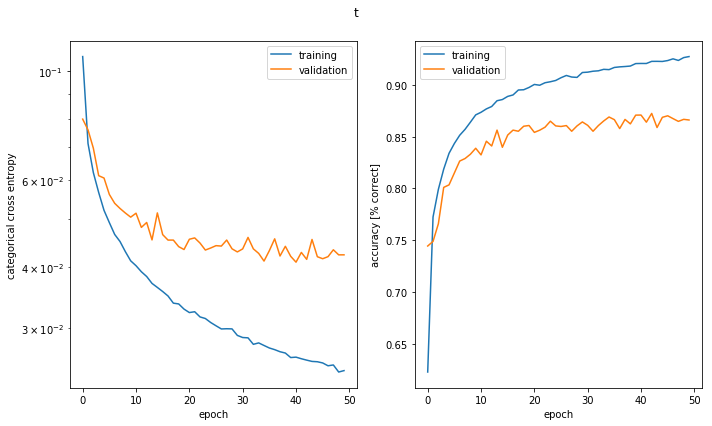

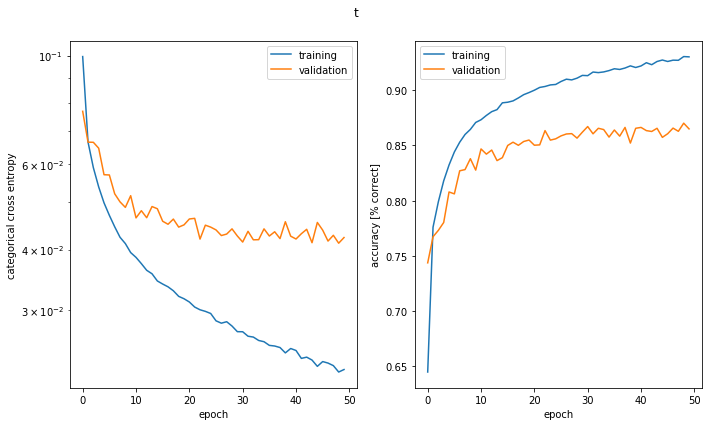

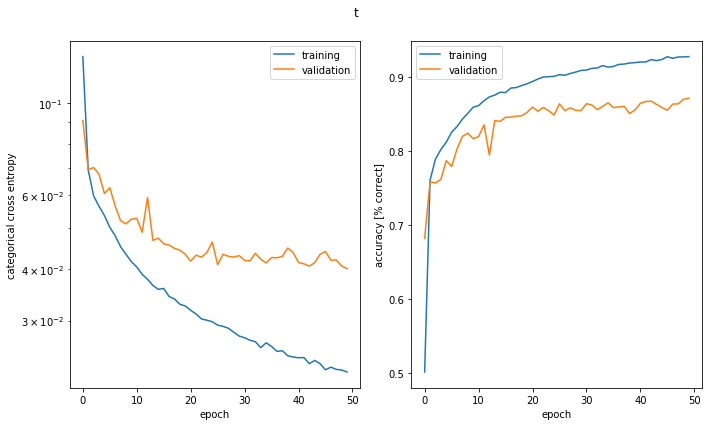

In [249]:
for h in layered_history:
    plot_history(h, 't')

In [253]:
for m in layered_models:
    print(m.evaluate(x_test, y_test, verbose=0)[1] * 100)

86.61657666165458
86.49917821084762
87.13312984268607


**Adam with softmax at output and categorical crossentropy:**

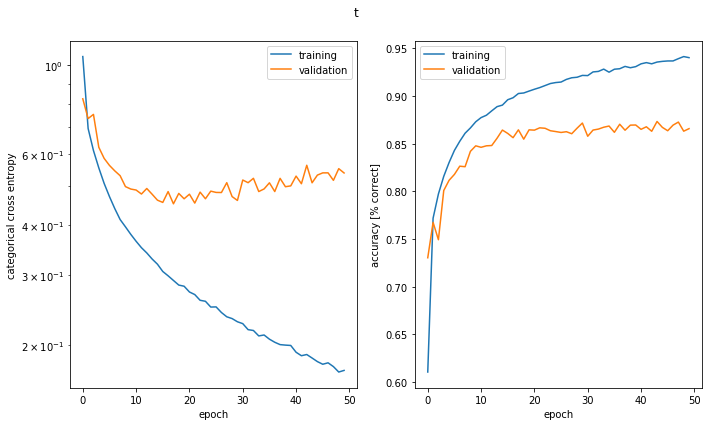

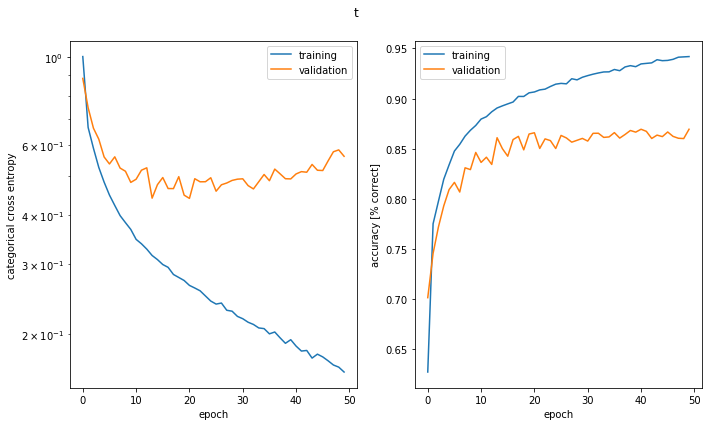

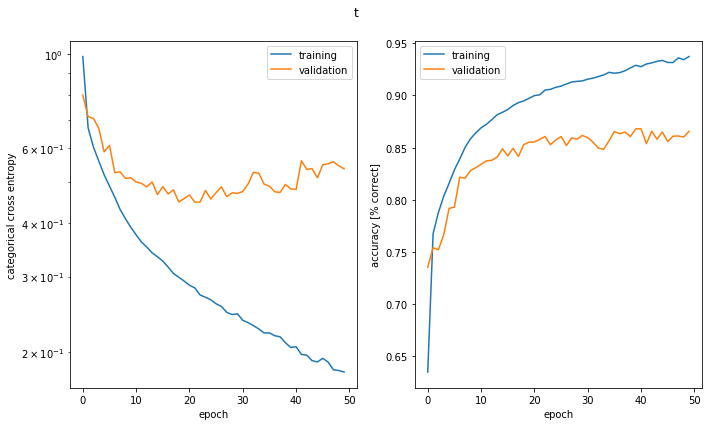

In [261]:
for h in layered_history:
    plot_history(h, 't')

In [262]:
for m in layered_models:
    print(m.evaluate(x_test, y_test, verbose=0)[1] * 100)

86.58527040869694
86.93746575925182
86.56179071769586


## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [74]:
from keras import backend as K

In [75]:
img_rows = img_cols = 16
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [65]:
np.mean(x_train, axis=1)

(33342,)

In [76]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [83]:
model.layers[0].input_shape

(None, 16, 16, 1)

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               295040    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
__________

In [78]:
history = model.fit(x_train, y_train, 
          batch_size=128,
          epochs=30,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 33342 samples, validate on 11946 samples
Epoch 1/30
33342/33342 [==============================] - 30s 898us/step - loss: 1.1146 - acc: 0.5577 - val_loss: 0.4978 - val_acc: 0.8617
Epoch 2/30
33342/33342 [==============================] - 26s 768us/step - loss: 0.4848 - acc: 0.8472 - val_loss: 0.3613 - val_acc: 0.8936
Epoch 3/30
33342/33342 [==============================] - 26s 771us/step - loss: 0.3917 - acc: 0.8770 - val_loss: 0.3072 - val_acc: 0.9073
Epoch 4/30
33342/33342 [==============================] - 26s 784us/step - loss: 0.3466 - acc: 0.8897 - val_loss: 0.2879 - val_acc: 0.9115
Epoch 5/30
33342/33342 [==============================] - 26s 777us/step - loss: 0.3211 - acc: 0.8963 - val_loss: 0.2756 - val_acc: 0.9119
Epoch 6/30
33342/33342 [==============================] - 27s 807us/step - loss: 0.2999 - acc: 0.9022 - val_loss: 0.2572 - val_acc: 0.9182
Epoch 7/30
33342/33342 [==============================] - 28s 837us/step - loss: 0.2895 - acc: 0.9062 - val_loss: 0.

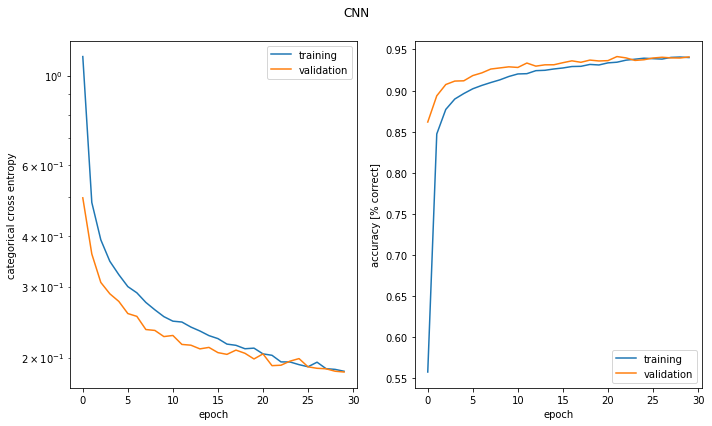

In [79]:
plot_history(history, 'CNN')

In [80]:
round(100 * score[1], 3)

94.09

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=256))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer= keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_194 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_195 (Dense)            (None, 5)                 2565      
Total params: 396,805
Trainable params: 396,805
Non-trainable params: 0
_________________________________________________________________
Train on 30060 samples, validate on 10288 samples
Epoch 1/20
